In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Meta Data Transfer - To GDrive
# !cp -r /content/recycle_train_resized /content/drive/MyDrive/DSML_Project_Meta_Data/
# !cp -r /content/recycle_test_resized /content/drive/MyDrive/DSML_Project_Meta_Data/
# !cp -r /content/recycle_trainset /content/drive/MyDrive/DSML_Project_Meta_Data/
# !cp -r /content/recycle_testset /content/drive/MyDrive/DSML_Project_Meta_Data/
# !cp /content/best_resnet50_model.h5 /content/drive/MyDrive/DSML_Project_Meta_Data/
# !cp /content/best_resnet101_model.h5 /content/drive/MyDrive/DSML_Project_Meta_Data/
# !cp /content/best_efficientnetb0_model.h5 /content/drive/MyDrive/DSML_Project_Meta_Data/
# !cp /content/best_vgg16_model.h5 /content/drive/MyDrive/DSML_Project_Meta_Data/

In [ ]:
# Meta Data Transfer - From GDrive
!cp -r /content/drive/MyDrive/DSML_Project_Meta_Data/recycle_train_resized/ /content/
!cp -r /content/drive/MyDrive/DSML_Project_Meta_Data/recycle_test_resized /content/
!cp -r /content/drive/MyDrive/DSML_Project_Meta_Data/recycle_trainset/ /content/
!cp -r /content/drive/MyDrive/DSML_Project_Meta_Data/recycle_testset/ /content/
!cp /content/drive/MyDrive/DSML_Project_Meta_Data/best_resnet50_model.h5 /content/
!cp /content/drive/MyDrive/DSML_Project_Meta_Data/best_resnet101_model.h5 /content/
!cp /content/drive/MyDrive/DSML_Project_Meta_Data/best_efficientnetb0_model.h5 /content/
!cp /content/drive/MyDrive/DSML_Project_Meta_Data/best_vgg16_model.h5 /content/

In [ ]:
# NAME: Abhijit Hanumeswara Kulkarni
# GITHUB USERNAME: abhijithanumeswarakulkarni
# USC ID: 5367018274

In [ ]:
# Imports
import os
from collections import defaultdict
from PIL import Image
import random
import shutil
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

1. Transfer Learning for Image Classification <br />
It is highly recommended that you complete this project using Keras1 and Python. <br />
(a) In this problem, we are trying to build a classifier that distinguishes images of nine types of waste.

In [ ]:
recycle_repo_path = '/content/drive/MyDrive/DSML_Project_Dataset/RealWaste'
waste_categories = sorted(os.listdir(recycle_repo_path))
print(f"Identified {len(waste_categories)} waste types:\n{waste_categories}")

bin_counts = {}
visual_dims = defaultdict(set)
file_encodings = defaultdict(set)

for waste_type in waste_categories:
    category_path = os.path.join(recycle_repo_path, waste_type)
    bin_items = sorted(os.listdir(category_path))
    bin_counts[waste_type] = len(bin_items)
    for visual_file in bin_items[:5]:
        image_path = os.path.join(category_path, visual_file)
        try:
            with Image.open(image_path) as visual:
                visual_dims[waste_type].add(visual.size)
                file_encodings[waste_type].add(visual.format)
        except Exception as issue:
            print(f"Unreadable image at {image_path}: {issue}")

print("\n📊 Waste Dataset Summary:")
for category in waste_categories:
    print(f"{category}: {bin_counts[category]} images | Shapes: {visual_dims[category]} | Formats: {file_encodings[category]}")

Identified 9 waste types:
['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']

📊 Waste Dataset Summary:
1-Cardboard: 461 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
2-Food Organics: 411 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
3-Glass: 420 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
4-Metal: 790 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
5-Miscellaneous Trash: 495 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
6-Paper: 500 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
7-Plastic: 921 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
8-Textile Trash: 318 images | Shapes: {(524, 524)} | Formats: {'JPEG'}
9-Vegetation: 436 images | Shapes: {(524, 524)} | Formats: {'JPEG'}


(b) Data Exploration and Pre-processing <br />
i. Images are numbered in each folder. Select the first 80% of the images in each folder as your training set and the rest as the test set. You can encode your classes using one-hot encoding.

In [ ]:
source_dir = '/content/drive/MyDrive/DSML_Project_Dataset/RealWaste'
train_root = '/content/recycle_trainset'
test_root = '/content/recycle_testset'

for folder in [train_root, test_root]:
    for waste_label in waste_categories:
        os.makedirs(os.path.join(folder, waste_label), exist_ok=True)

for waste_label in waste_categories:
    origin_path = os.path.join(source_dir, waste_label)
    contents = sorted(os.listdir(origin_path))
    random.shuffle(contents)
    cutoff = int(0.8 * len(contents))
    train_files = contents[:cutoff]
    test_files = contents[cutoff:]

    for f in train_files:
        shutil.copyfile(os.path.join(origin_path, f), os.path.join(train_root, waste_label, f))
    for f in test_files:
        shutil.copyfile(os.path.join(origin_path, f), os.path.join(test_root, waste_label, f))

ii. In case all the images do not have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [ ]:
resize_dim = (224, 224)

def preprocess_folder(source_root, target_root):
    for label_name in waste_categories:
        input_dir = os.path.join(source_root, label_name)
        output_dir = os.path.join(target_root, label_name)
        os.makedirs(output_dir, exist_ok=True)
        for img_file in sorted(os.listdir(input_dir)):
            src_path = os.path.join(input_dir, img_file)
            dst_path = os.path.join(output_dir, img_file)
            try:
                raw = cv2.imread(src_path)
                resized = cv2.resize(raw, resize_dim, interpolation=cv2.INTER_AREA)
                cv2.imwrite(dst_path, resized)
            except:
                pass

preprocess_folder(train_root, '/content/recycle_train_resized')
preprocess_folder(test_root, '/content/recycle_test_resized')

(c) Transfer Learning <br />
i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, you will use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16. For those pre-trained networks, you will only
train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the
penultimate layer in the original pre-trained model as the features extracted from each image. <br />

(ii) To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV. <br />

(iii) Use ReLU activation functions in the last layer and a softmax layer, along with L2 regularization, batch normalization 3, and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable. <br />

(iv) iv. Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs. <br />

(v) Report training, validation, and test Precision, Recall, AUC, and F1 score for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem.

In [53]:
augmented_loader = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    fill_mode='nearest'
)

aug_train_flow = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training'
)

aug_val_flow = augmented_loader.flow_from_directory(
    '/content/recycle_train_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='validation'
)

res_eval = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/recycle_test_resized',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

Found 3042 images belonging to 9 classes.
Found 756 images belonging to 9 classes.
Found 954 images belonging to 9 classes.


In [54]:
base_extractor = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_extractor.layers:
    layer.trainable = False

x = base_extractor.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out_layer = Dense(9, activation='softmax')(x)

res_model = Model(inputs=base_extractor.input, outputs=out_layer)
res_model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [55]:
checkpoint_path = '/content/best_resnet50_augmented_model.h5'

halt = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
saver = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)

history_aug_resnet50 = res_model.fit(
    aug_train_flow,
    epochs=100,
    validation_data=aug_val_flow,
    callbacks=[halt, saver],
    verbose=1
)

Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.1877 - loss: 6.1132

381/381 ━━━━━━━━━━━━━━━━━━━━ 66s 145ms/step - accuracy: 0.1878 - loss: 6.1110 - val_accuracy: 0.2447 - val_loss: 3.9294
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.2778 - loss: 3.8920

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.2778 - loss: 3.8916 - val_accuracy: 0.3294 - val_loss: 3.4516
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3023 - loss: 3.5348

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.3023 - loss: 3.5347 - val_accuracy: 0.3479 - val_loss: 3.2627
Epoch 4/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3135 - loss: 3.3994

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.3135 - loss: 3.3991 - val_accuracy: 0.3479 - val_loss: 3.1872
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3279 - loss: 3.2219

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.3279 - loss: 3.2218 - val_accuracy: 0.3690 - val_loss: 3.0211
Epoch 6/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3409 - loss: 3.0643

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.3409 - loss: 3.0643 - val_accuracy: 0.3915 - val_loss: 2.9069
Epoch 7/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3572 - loss: 2.9664

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.3572 - loss: 2.9665 - val_accuracy: 0.3876 - val_loss: 2.8422
Epoch 8/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3388 - loss: 2.9336

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.3388 - loss: 2.9335 - val_accuracy: 0.3823 - val_loss: 2.7759
Epoch 9/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.3512 - loss: 2.8237 - val_accuracy: 0.3836 - val_loss: 2.7808
Epoch 10/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3759 - loss: 2.7711

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.3759 - loss: 2.7710 - val_accuracy: 0.3730 - val_loss: 2.6816
Epoch 11/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3753 - loss: 2.7168

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.3753 - loss: 2.7167 - val_accuracy: 0.4272 - val_loss: 2.6020
Epoch 12/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3446 - loss: 2.6793

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.3447 - loss: 2.6792 - val_accuracy: 0.3995 - val_loss: 2.6005
Epoch 13/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3847 - loss: 2.5477

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.3847 - loss: 2.5477 - val_accuracy: 0.4008 - val_loss: 2.5378
Epoch 14/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3920 - loss: 2.5113

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.3920 - loss: 2.5114 - val_accuracy: 0.4087 - val_loss: 2.4868
Epoch 15/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3887 - loss: 2.4682

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.3887 - loss: 2.4682 - val_accuracy: 0.4061 - val_loss: 2.4719
Epoch 16/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3841 - loss: 2.4358

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.3840 - loss: 2.4359 - val_accuracy: 0.4008 - val_loss: 2.4570
Epoch 17/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3943 - loss: 2.3962

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.3944 - loss: 2.3962 - val_accuracy: 0.4021 - val_loss: 2.4002
Epoch 18/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4116 - loss: 2.3231

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4116 - loss: 2.3232 - val_accuracy: 0.4206 - val_loss: 2.3335
Epoch 19/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4193 - loss: 2.2674

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4193 - loss: 2.2676 - val_accuracy: 0.4167 - val_loss: 2.3106
Epoch 20/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4220 - loss: 2.2587 - val_accuracy: 0.4101 - val_loss: 2.3217
Epoch 21/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4072 - loss: 2.2554

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.4072 - loss: 2.2555 - val_accuracy: 0.4048 - val_loss: 2.2995
Epoch 22/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4243 - loss: 2.2134

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.4243 - loss: 2.2134 - val_accuracy: 0.4352 - val_loss: 2.2873
Epoch 23/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4079 - loss: 2.2273

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.4079 - loss: 2.2272 - val_accuracy: 0.4008 - val_loss: 2.2435
Epoch 24/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4008 - loss: 2.2404

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4009 - loss: 2.2403 - val_accuracy: 0.4299 - val_loss: 2.1698
Epoch 25/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4282 - loss: 2.1430 - val_accuracy: 0.4140 - val_loss: 2.1729
Epoch 26/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.4187 - loss: 2.1199 - val_accuracy: 0.4140 - val_loss: 2.1821
Epoch 27/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4363 - loss: 2.0987

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4363 - loss: 2.0988 - val_accuracy: 0.4458 - val_loss: 2.0917
Epoch 28/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4253 - loss: 2.0733 - val_accuracy: 0.4259 - val_loss: 2.1658
Epoch 29/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4089 - loss: 2.0743

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4089 - loss: 2.0742 - val_accuracy: 0.4167 - val_loss: 2.0723
Epoch 30/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.3996 - loss: 2.0906 - val_accuracy: 0.4220 - val_loss: 2.1177
Epoch 31/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4253 - loss: 2.0805

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4253 - loss: 2.0804 - val_accuracy: 0.4206 - val_loss: 2.0579
Epoch 32/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4155 - loss: 2.0486

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4156 - loss: 2.0485 - val_accuracy: 0.4603 - val_loss: 1.9973
Epoch 33/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4257 - loss: 1.9937 - val_accuracy: 0.4272 - val_loss: 2.0539
Epoch 34/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4269 - loss: 1.9961 - val_accuracy: 0.3968 - val_loss: 2.0244
Epoch 35/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4242 - loss: 1.9882 - val_accuracy: 0.3929 - val_loss: 2.0245
Epoch 36/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4440 - loss: 1.9139 - val_accuracy: 0.4233 - val_loss: 2.0595
Epoch 37/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4574 - loss: 1.8858 - val_accuracy: 0.4127 - val_loss: 2.0027
Epoch 38/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4421 - loss: 1.8749 - val_accuracy: 0.4444 - val_loss: 2.0027
Epoch 39/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4482 - loss: 

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4481 - loss: 1.9034 - val_accuracy: 0.4259 - val_loss: 1.9694
Epoch 40/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4557 - loss: 1.8664

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4556 - loss: 1.8665 - val_accuracy: 0.4339 - val_loss: 1.9201
Epoch 41/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4449 - loss: 1.8890 - val_accuracy: 0.4378 - val_loss: 1.9657
Epoch 42/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4245 - loss: 1.9130 - val_accuracy: 0.4259 - val_loss: 1.9591
Epoch 43/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4434 - loss: 1.8135

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4434 - loss: 1.8135 - val_accuracy: 0.4286 - val_loss: 1.9004
Epoch 44/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4445 - loss: 1.8434

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.4445 - loss: 1.8435 - val_accuracy: 0.4444 - val_loss: 1.8869
Epoch 45/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4588 - loss: 1.8300 - val_accuracy: 0.4074 - val_loss: 1.9118
Epoch 46/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4460 - loss: 1.8235 - val_accuracy: 0.4392 - val_loss: 1.8992
Epoch 47/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4466 - loss: 1.8263

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.4466 - loss: 1.8263 - val_accuracy: 0.4339 - val_loss: 1.8448
Epoch 48/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4509 - loss: 1.7862 - val_accuracy: 0.4339 - val_loss: 1.8669
Epoch 49/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.4270 - loss: 1.8335 - val_accuracy: 0.4286 - val_loss: 1.8884
Epoch 50/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4284 - loss: 1.8098 - val_accuracy: 0.4299 - val_loss: 1.8792
Epoch 51/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4730 - loss: 1.7388

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.4729 - loss: 1.7389 - val_accuracy: 0.4458 - val_loss: 1.8295
Epoch 52/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.4695 - loss: 1.7394 - val_accuracy: 0.4272 - val_loss: 1.8951
Epoch 53/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4502 - loss: 1.7858 - val_accuracy: 0.4008 - val_loss: 1.9124
Epoch 54/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4578 - loss: 1.7688 - val_accuracy: 0.4233 - val_loss: 1.8567
Epoch 55/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4623 - loss: 1.7370 - val_accuracy: 0.4392 - val_loss: 1.8499
Epoch 56/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4543 - loss: 1.7717

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4543 - loss: 1.7717 - val_accuracy: 0.4524 - val_loss: 1.8252
Epoch 57/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4668 - loss: 1.7565 - val_accuracy: 0.4352 - val_loss: 1.8725
Epoch 58/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4265 - loss: 1.7824 - val_accuracy: 0.4220 - val_loss: 1.8571
Epoch 59/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4534 - loss: 1.7462

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.4534 - loss: 1.7462 - val_accuracy: 0.4471 - val_loss: 1.8206
Epoch 60/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4519 - loss: 1.7218 - val_accuracy: 0.4458 - val_loss: 1.8446
Epoch 61/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4384 - loss: 1.7420 - val_accuracy: 0.4392 - val_loss: 1.8832
Epoch 62/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4515 - loss: 1.7380 - val_accuracy: 0.4153 - val_loss: 1.8764
Epoch 63/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4512 - loss: 1.7379 - val_accuracy: 0.4220 - val_loss: 1.8271
Epoch 64/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4652 - loss: 1.7179 - val_accuracy: 0.4405 - val_loss: 1.8210
Epoch 65/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4347 - loss: 1.7745

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4347 - loss: 1.7744 - val_accuracy: 0.4444 - val_loss: 1.8159
Epoch 66/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4525 - loss: 1.7170

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4525 - loss: 1.7170 - val_accuracy: 0.4550 - val_loss: 1.8147
Epoch 67/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4678 - loss: 1.6480 - val_accuracy: 0.4365 - val_loss: 1.8337
Epoch 68/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4524 - loss: 1.7205 - val_accuracy: 0.4087 - val_loss: 1.8165
Epoch 69/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4664 - loss: 1.6967

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4664 - loss: 1.6967 - val_accuracy: 0.4444 - val_loss: 1.7966
Epoch 70/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4567 - loss: 1.6852

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4567 - loss: 1.6852 - val_accuracy: 0.4325 - val_loss: 1.7924
Epoch 71/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4568 - loss: 1.6671 - val_accuracy: 0.4484 - val_loss: 1.8182
Epoch 72/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4719 - loss: 1.6281 - val_accuracy: 0.4497 - val_loss: 1.8137
Epoch 73/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4739 - loss: 1.6631

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4739 - loss: 1.6631 - val_accuracy: 0.4365 - val_loss: 1.7861
Epoch 74/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4524 - loss: 1.6879 - val_accuracy: 0.4220 - val_loss: 1.8136
Epoch 75/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4753 - loss: 1.6480

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.4753 - loss: 1.6480 - val_accuracy: 0.4550 - val_loss: 1.7795
Epoch 76/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4367 - loss: 1.7247 - val_accuracy: 0.4339 - val_loss: 1.7868
Epoch 77/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4412 - loss: 1.7061

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4412 - loss: 1.7060 - val_accuracy: 0.4511 - val_loss: 1.7442
Epoch 78/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4683 - loss: 1.6629 - val_accuracy: 0.4339 - val_loss: 1.7823
Epoch 79/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4678 - loss: 1.6609 - val_accuracy: 0.4286 - val_loss: 1.7827
Epoch 80/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4550 - loss: 1.6573 - val_accuracy: 0.4378 - val_loss: 1.7743
Epoch 81/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4464 - loss: 1.6688 - val_accuracy: 0.4418 - val_loss: 1.7465
Epoch 82/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4512 - loss: 1.6510 - val_accuracy: 0.4497 - val_loss: 1.7484
Epoch 83/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4749 - loss: 1.6431 - val_accuracy: 0.4511 - val_loss: 1.7919
Epoch 84/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4829 - loss

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4707 - loss: 1.6246 - val_accuracy: 0.4365 - val_loss: 1.7264
Epoch 88/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4669 - loss: 1.6358 - val_accuracy: 0.4352 - val_loss: 1.7533
Epoch 89/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4717 - loss: 1.6286 - val_accuracy: 0.4418 - val_loss: 1.7393
Epoch 90/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4640 - loss: 1.6472 - val_accuracy: 0.4484 - val_loss: 1.7558
Epoch 91/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.4566 - loss: 1.6747 - val_accuracy: 0.4511 - val_loss: 1.7281
Epoch 92/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4590 - loss: 1.6331 - val_accuracy: 0.4167 - val_loss: 1.7749
Epoch 93/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4746 - loss: 1.6380 - val_accuracy: 0.4272 - val_loss: 1.7566
Epoch 94/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.4495 - loss

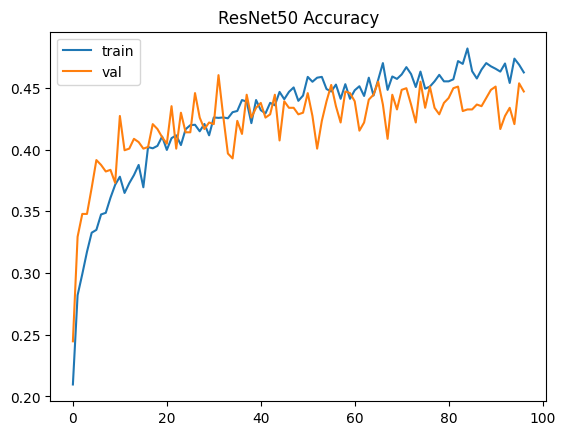

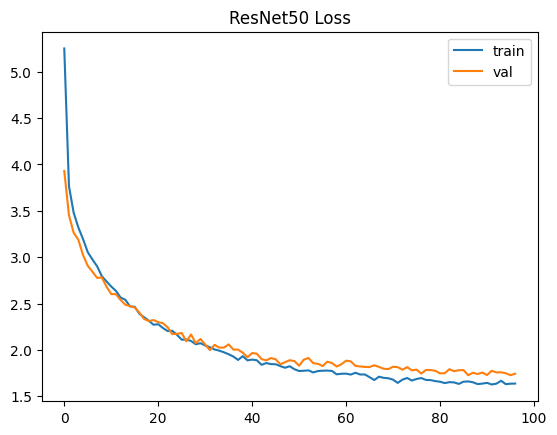

In [56]:
plt.plot(history_aug_resnet50.history['accuracy'], label='train')
plt.plot(history_aug_resnet50.history['val_accuracy'], label='val')
plt.title('ResNet50 Accuracy')
plt.legend()
plt.show()

plt.plot(history_aug_resnet50.history['loss'], label='train')
plt.plot(history_aug_resnet50.history['val_loss'], label='val')
plt.title('ResNet50 Loss')
plt.legend()
plt.show()

In [59]:
# Training set evaluations
aug_train_flow.reset()
true_labels = aug_train_flow.classes
predicted_probs = res_model.predict(aug_train_flow, verbose=1)
predicted_labels = np.argmax(predicted_probs, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=aug_train_flow.class_indices.keys()))

macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
macro_prec = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
onehot_labels = np.eye(9)[true_labels]
macro_auc = roc_auc_score(onehot_labels, predicted_probs, multi_class='ovr', average='macro')

print(f'Train F1: {macro_f1:.4f} | Precision: {macro_prec:.4f} | Recall: {macro_recall:.4f} | AUC: {macro_auc:.4f}')

381/381 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.08      0.07      0.08       295
      2-Food Organics       0.09      0.10      0.09       263
              3-Glass       0.05      0.02      0.03       269
              4-Metal       0.18      0.24      0.20       506
5-Miscellaneous Trash       0.11      0.05      0.07       317
              6-Paper       0.10      0.07      0.08       320
            7-Plastic       0.21      0.31      0.25       589
      8-Textile Trash       0.08      0.04      0.06       204
         9-Vegetation       0.11      0.13      0.12       279

             accuracy                           0.14      3042
            macro avg       0.11      0.12      0.11      3042
         weighted avg       0.13      0.14      0.13      3042

Train F1: 0.1087 | Precision: 0.1114 | Recall: 0.1150 | AUC: 0.4955


In [60]:
# Validation set evaluations
aug_val_flow.reset()
true_labels = aug_val_flow.classes
predicted_probs = res_model.predict(aug_val_flow, verbose=1)
predicted_labels = np.argmax(predicted_probs, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=aug_val_flow.class_indices.keys()))

macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
macro_prec = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
onehot_labels = np.eye(9)[true_labels]
macro_auc = roc_auc_score(onehot_labels, predicted_probs, multi_class='ovr', average='macro')

print(f'Val F1: {macro_f1:.4f} | Precision: {macro_prec:.4f} | Recall: {macro_recall:.4f} | AUC: {macro_auc:.4f}')

95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.05      0.03      0.04        73
      2-Food Organics       0.16      0.15      0.16        65
              3-Glass       0.08      0.04      0.06        67
              4-Metal       0.16      0.25      0.19       126
5-Miscellaneous Trash       0.15      0.08      0.10        79
              6-Paper       0.03      0.03      0.03        80
            7-Plastic       0.22      0.29      0.25       147
      8-Textile Trash       0.08      0.08      0.08        50
         9-Vegetation       0.14      0.16      0.15        69

             accuracy                           0.15       756
            macro avg       0.12      0.12      0.12       756
         weighted avg       0.13      0.15      0.13       756

Val F1: 0.1166 | Precision: 0.1193 | Recall: 0.1220 | AUC: 0.5062


In [61]:
# Test set evaluations
res_eval.reset()
true_labels = res_eval.classes
predicted_probs = res_model.predict(res_eval, verbose=1)
predicted_labels = np.argmax(predicted_probs, axis=1)
print(classification_report(true_labels, predicted_labels, target_names=res_eval.class_indices.keys()))

macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
macro_prec = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
onehot_labels = np.eye(9)[true_labels]
macro_auc = roc_auc_score(onehot_labels, predicted_probs, multi_class='ovr', average='macro')

print(f'F1: {macro_f1:.4f} | Precision: {macro_prec:.4f} | Recall: {macro_recall:.4f} | AUC: {macro_auc:.4f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.53      0.43      0.48        93
      2-Food Organics       0.55      0.75      0.63        83
              3-Glass       0.59      0.19      0.29        84
              4-Metal       0.44      0.70      0.54       158
5-Miscellaneous Trash       0.42      0.19      0.26        99
              6-Paper       0.54      0.37      0.44       100
            7-Plastic       0.53      0.63      0.58       185
      8-Textile Trash       0.48      0.20      0.29        64
         9-Vegetation       0.59      0.85      0.70        88

             accuracy                           0.51       954
            macro avg       0.52      0.48      0.47       954
         weighted avg       0.52      0.51      0.49       954

F1: 0.4670 | Precision: 0.5199 | Recall: 0.4800 | AUC: 0.8726


In [66]:
# ResNet100
res101_base = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in res101_base.layers:
    layer.trainable = False

z = res101_base.output
z = GlobalAveragePooling2D()(z)
z = BatchNormalization()(z)
z = Dropout(0.3)(z)
z = Dense(256, activation='relu', kernel_regularizer='l2')(z)
z = BatchNormalization()(z)
z = Dropout(0.3)(z)
res101_out = Dense(9, activation='softmax')(z)

res101_model = Model(inputs=res101_base.input, outputs=res101_out)
res101_model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [67]:
res101_ckpt = '/content/best_resnet101_augmented_model.h5'

early_stop_101 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_save_101 = ModelCheckpoint(filepath=res101_ckpt, monitor='val_loss', save_best_only=True)

res101_history = res101_model.fit(
    aug_train_flow,
    epochs=100,
    validation_data=aug_val_flow,
    callbacks=[early_stop_101, model_save_101],
    verbose=1
)

Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.1738 - loss: 6.1209

381/381 ━━━━━━━━━━━━━━━━━━━━ 81s 163ms/step - accuracy: 0.1739 - loss: 6.1184 - val_accuracy: 0.2778 - val_loss: 3.6477
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2625 - loss: 3.7635

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.2625 - loss: 3.7631 - val_accuracy: 0.3413 - val_loss: 3.2101
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2831 - loss: 3.3587

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.2831 - loss: 3.3587 - val_accuracy: 0.3571 - val_loss: 3.0536
Epoch 4/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.2788 - loss: 3.2094

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.2788 - loss: 3.2093 - val_accuracy: 0.3333 - val_loss: 2.9995
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3229 - loss: 3.0247

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.3228 - loss: 3.0247 - val_accuracy: 0.3810 - val_loss: 2.8330
Epoch 6/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3120 - loss: 3.0297

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.3120 - loss: 3.0296 - val_accuracy: 0.3717 - val_loss: 2.8034
Epoch 7/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3182 - loss: 2.8878

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.3182 - loss: 2.8878 - val_accuracy: 0.3717 - val_loss: 2.7190
Epoch 8/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3419 - loss: 2.8139

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.3419 - loss: 2.8140 - val_accuracy: 0.3836 - val_loss: 2.5968
Epoch 9/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3349 - loss: 2.7304

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.3348 - loss: 2.7305 - val_accuracy: 0.3743 - val_loss: 2.5771
Epoch 10/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.3406 - loss: 2.7031 - val_accuracy: 0.3558 - val_loss: 2.5922
Epoch 11/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3613 - loss: 2.6331

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.3613 - loss: 2.6331 - val_accuracy: 0.3823 - val_loss: 2.5301
Epoch 12/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3318 - loss: 2.6086

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.3319 - loss: 2.6085 - val_accuracy: 0.3902 - val_loss: 2.4412
Epoch 13/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3578 - loss: 2.5506

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.3578 - loss: 2.5506 - val_accuracy: 0.3704 - val_loss: 2.4155
Epoch 14/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3391 - loss: 2.5309

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.3391 - loss: 2.5309 - val_accuracy: 0.3532 - val_loss: 2.3993
Epoch 15/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3310 - loss: 2.5067

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.3310 - loss: 2.5066 - val_accuracy: 0.3849 - val_loss: 2.3859
Epoch 16/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3629 - loss: 2.4144

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.3629 - loss: 2.4144 - val_accuracy: 0.3757 - val_loss: 2.3411
Epoch 17/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3625 - loss: 2.3924

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.3625 - loss: 2.3924 - val_accuracy: 0.3770 - val_loss: 2.2853
Epoch 18/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3754 - loss: 2.3393

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.3754 - loss: 2.3394 - val_accuracy: 0.3704 - val_loss: 2.2790
Epoch 19/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3749 - loss: 2.3392

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.3749 - loss: 2.3391 - val_accuracy: 0.3796 - val_loss: 2.2427
Epoch 20/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3704 - loss: 2.2983

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.3705 - loss: 2.2983 - val_accuracy: 0.3995 - val_loss: 2.2181
Epoch 21/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3756 - loss: 2.2743

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.3756 - loss: 2.2743 - val_accuracy: 0.3810 - val_loss: 2.2112
Epoch 22/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3658 - loss: 2.2294

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.3658 - loss: 2.2295 - val_accuracy: 0.3624 - val_loss: 2.1957
Epoch 23/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3873 - loss: 2.1892

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.3873 - loss: 2.1893 - val_accuracy: 0.4008 - val_loss: 2.1538
Epoch 24/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3852 - loss: 2.1773

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.3852 - loss: 2.1774 - val_accuracy: 0.3902 - val_loss: 2.1255
Epoch 25/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.3737 - loss: 2.1838 - val_accuracy: 0.3849 - val_loss: 2.1517
Epoch 26/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3793 - loss: 2.1386

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.3793 - loss: 2.1387 - val_accuracy: 0.3876 - val_loss: 2.0863
Epoch 27/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.3834 - loss: 2.1387 - val_accuracy: 0.3876 - val_loss: 2.1073
Epoch 28/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3971 - loss: 2.1180

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.3971 - loss: 2.1180 - val_accuracy: 0.3981 - val_loss: 2.0692
Epoch 29/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3962 - loss: 2.1104

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.3962 - loss: 2.1104 - val_accuracy: 0.4325 - val_loss: 2.0607
Epoch 30/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.3812 - loss: 2.0742 - val_accuracy: 0.4127 - val_loss: 2.0798
Epoch 31/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.3725 - loss: 2.0682 - val_accuracy: 0.4101 - val_loss: 2.0756
Epoch 32/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.3821 - loss: 2.0629 - val_accuracy: 0.3929 - val_loss: 2.0687
Epoch 33/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3887 - loss: 2.0470

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.3887 - loss: 2.0470 - val_accuracy: 0.4127 - val_loss: 2.0029
Epoch 34/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3976 - loss: 2.0175

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.3976 - loss: 2.0175 - val_accuracy: 0.4048 - val_loss: 1.9964
Epoch 35/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4025 - loss: 1.9951

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.4025 - loss: 1.9951 - val_accuracy: 0.3929 - val_loss: 1.9947
Epoch 36/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3865 - loss: 1.9843

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.3865 - loss: 1.9843 - val_accuracy: 0.3862 - val_loss: 1.9913
Epoch 37/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4082 - loss: 1.9741

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.4082 - loss: 1.9741 - val_accuracy: 0.4101 - val_loss: 1.9570
Epoch 38/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4193 - loss: 1.9164 - val_accuracy: 0.3902 - val_loss: 1.9836
Epoch 39/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4136 - loss: 1.9285 - val_accuracy: 0.3929 - val_loss: 1.9836
Epoch 40/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4022 - loss: 1.9299

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.4022 - loss: 1.9299 - val_accuracy: 0.4220 - val_loss: 1.9452
Epoch 41/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4193 - loss: 1.9496

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.4192 - loss: 1.9497 - val_accuracy: 0.4312 - val_loss: 1.9132
Epoch 42/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.4125 - loss: 1.9218 - val_accuracy: 0.4167 - val_loss: 1.9468
Epoch 43/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.3997 - loss: 1.9305 - val_accuracy: 0.4140 - val_loss: 1.9194
Epoch 44/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4011 - loss: 1.9254

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.4011 - loss: 1.9254 - val_accuracy: 0.4087 - val_loss: 1.8826
Epoch 45/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4077 - loss: 1.9169 - val_accuracy: 0.4286 - val_loss: 1.9023
Epoch 46/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4077 - loss: 1.8855 - val_accuracy: 0.4140 - val_loss: 1.9033
Epoch 47/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.3956 - loss: 1.8745 - val_accuracy: 0.4153 - val_loss: 1.9264
Epoch 48/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4099 - loss: 1.8714 - val_accuracy: 0.4074 - val_loss: 1.9712
Epoch 49/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4151 - loss: 1.8351 - val_accuracy: 0.4034 - val_loss: 1.9578
Epoch 50/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.4187 - loss: 1.8423 - val_accuracy: 0.4101 - val_loss: 1.8836
Epoch 51/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4062 - loss

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.4294 - loss: 1.8118 - val_accuracy: 0.4021 - val_loss: 1.8681
Epoch 53/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.4092 - loss: 1.8400 - val_accuracy: 0.4008 - val_loss: 1.9254
Epoch 54/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4394 - loss: 1.7840

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.4393 - loss: 1.7841 - val_accuracy: 0.4153 - val_loss: 1.8503
Epoch 55/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4158 - loss: 1.8223

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.4158 - loss: 1.8223 - val_accuracy: 0.4206 - val_loss: 1.8286
Epoch 56/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4284 - loss: 1.7676 - val_accuracy: 0.4021 - val_loss: 1.8584
Epoch 57/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.4093 - loss: 1.7969 - val_accuracy: 0.4206 - val_loss: 1.8308
Epoch 58/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4244 - loss: 1.8094

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.4244 - loss: 1.8094 - val_accuracy: 0.4021 - val_loss: 1.8046
Epoch 59/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.4188 - loss: 1.8115 - val_accuracy: 0.4180 - val_loss: 1.8207
Epoch 60/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4153 - loss: 1.8204 - val_accuracy: 0.4008 - val_loss: 1.8222
Epoch 61/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4170 - loss: 1.7723 - val_accuracy: 0.3915 - val_loss: 1.8600
Epoch 62/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4301 - loss: 1.7878

381/381 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.4300 - loss: 1.7878 - val_accuracy: 0.4114 - val_loss: 1.8005
Epoch 63/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4216 - loss: 1.7677

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.4216 - loss: 1.7677 - val_accuracy: 0.4299 - val_loss: 1.7874
Epoch 64/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4234 - loss: 1.7632 - val_accuracy: 0.4220 - val_loss: 1.8279
Epoch 65/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4263 - loss: 1.7719 - val_accuracy: 0.4074 - val_loss: 1.8395
Epoch 66/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4373 - loss: 1.7374 - val_accuracy: 0.4048 - val_loss: 1.8093
Epoch 67/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4307 - loss: 1.7283 - val_accuracy: 0.4008 - val_loss: 1.8033
Epoch 68/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.4275 - loss: 1.7344 - val_accuracy: 0.4048 - val_loss: 1.7965
Epoch 69/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.4522 - loss: 1.7394 - val_accuracy: 0.4206 - val_loss: 1.7878
Epoch 70/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.4254 - loss

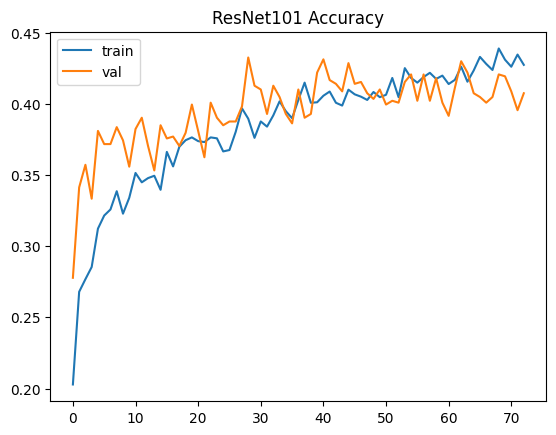

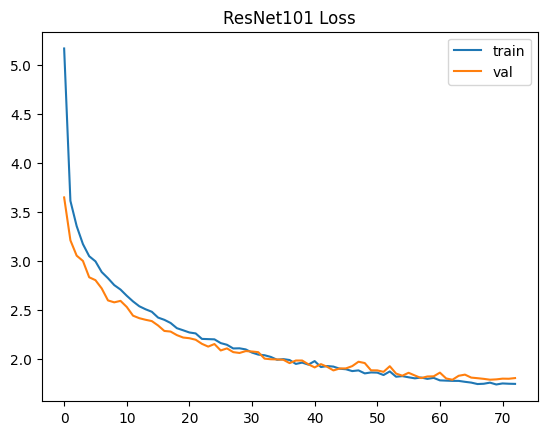

In [68]:
plt.plot(res101_history.history['accuracy'], label='train')
plt.plot(res101_history.history['val_accuracy'], label='val')
plt.title('ResNet101 Accuracy')
plt.legend()
plt.show()

plt.plot(res101_history.history['loss'], label='train')
plt.plot(res101_history.history['val_loss'], label='val')
plt.title('ResNet101 Loss')
plt.legend()
plt.show()

In [69]:
# Train set evaluations
aug_train_flow.reset()
true_labels_101 = aug_train_flow.classes
predicted_probs_101 = res101_model.predict(aug_train_flow, verbose=1)
predicted_labels_101 = np.argmax(predicted_probs_101, axis=1)

print(classification_report(true_labels_101, predicted_labels_101, target_names=aug_train_flow.class_indices.keys()))

macro_f1_101 = f1_score(true_labels_101, predicted_labels_101, average='macro')
macro_prec_101 = precision_score(true_labels_101, predicted_labels_101, average='macro')
macro_recall_101 = recall_score(true_labels_101, predicted_labels_101, average='macro')
onehot_101 = np.eye(9)[true_labels_101]
macro_auc_101 = roc_auc_score(onehot_101, predicted_probs_101, multi_class='ovr', average='macro')

print(f'Train F1: {macro_f1_101:.4f} | Precision: {macro_prec_101:.4f} | Recall: {macro_recall_101:.4f} | AUC: {macro_auc_101:.4f}')

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.10      0.07      0.08       295
      2-Food Organics       0.06      0.06      0.06       263
              3-Glass       0.07      0.07      0.07       269
              4-Metal       0.17      0.22      0.19       506
5-Miscellaneous Trash       0.15      0.06      0.08       317
              6-Paper       0.12      0.09      0.10       320
            7-Plastic       0.20      0.27      0.23       589
      8-Textile Trash       0.03      0.02      0.03       204
         9-Vegetation       0.09      0.10      0.10       279

             accuracy                           0.13      3042
            macro avg       0.11      0.11      0.10      3042
         weighted avg       0.13      0.13      0.13      3042

Train F1: 0.1048 | Precision: 0.1094 | Recall: 0.1074 | AUC: 0.4898


In [70]:
# Validation set evaluations
aug_val_flow.reset()
true_labels_101 = aug_val_flow.classes
predicted_probs_101 = res101_model.predict(aug_val_flow, verbose=1)
predicted_labels_101 = np.argmax(predicted_probs_101, axis=1)

print(classification_report(true_labels_101, predicted_labels_101, target_names=aug_val_flow.class_indices.keys()))

macro_f1_101 = f1_score(true_labels_101, predicted_labels_101, average='macro')
macro_prec_101 = precision_score(true_labels_101, predicted_labels_101, average='macro')
macro_recall_101 = recall_score(true_labels_101, predicted_labels_101, average='macro')
onehot_101 = np.eye(9)[true_labels_101]
macro_auc_101 = roc_auc_score(onehot_101, predicted_probs_101, multi_class='ovr', average='macro')

print(f'Val F1: {macro_f1_101:.4f} | Precision: {macro_prec_101:.4f} | Recall: {macro_recall_101:.4f} | AUC: {macro_auc_101:.4f}')

95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.08      0.07      0.08        73
      2-Food Organics       0.10      0.06      0.07        65
              3-Glass       0.10      0.12      0.11        67
              4-Metal       0.14      0.22      0.17       126
5-Miscellaneous Trash       0.09      0.04      0.05        79
              6-Paper       0.06      0.04      0.05        80
            7-Plastic       0.23      0.26      0.24       147
      8-Textile Trash       0.09      0.08      0.08        50
         9-Vegetation       0.09      0.12      0.10        69

             accuracy                           0.13       756
            macro avg       0.11      0.11      0.11       756
         weighted avg       0.12      0.13      0.13       756

Val F1: 0.1070 | Precision: 0.1097 | Recall: 0.1113 | AUC: 0.4941


In [71]:
# Test set evaluations
res_eval.reset()
true_labels_101 = res_eval.classes
predicted_probs_101 = res101_model.predict(res_eval, verbose=1)
predicted_labels_101 = np.argmax(predicted_probs_101, axis=1)

print(classification_report(true_labels_101, predicted_labels_101, target_names=res_eval.class_indices.keys()))

macro_f1_101 = f1_score(true_labels_101, predicted_labels_101, average='macro')
macro_prec_101 = precision_score(true_labels_101, predicted_labels_101, average='macro')
macro_recall_101 = recall_score(true_labels_101, predicted_labels_101, average='macro')
onehot_101 = np.eye(9)[true_labels_101]
macro_auc_101 = roc_auc_score(onehot_101, predicted_probs_101, multi_class='ovr', average='macro')

print(f'F1: {macro_f1_101:.4f} | Precision: {macro_prec_101:.4f} | Recall: {macro_recall_101:.4f} | AUC: {macro_auc_101:.4f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.41      0.27      0.32        93
      2-Food Organics       0.54      0.65      0.59        83
              3-Glass       0.58      0.31      0.40        84
              4-Metal       0.44      0.66      0.53       158
5-Miscellaneous Trash       0.31      0.11      0.16        99
              6-Paper       0.41      0.29      0.34       100
            7-Plastic       0.45      0.56      0.50       185
      8-Textile Trash       0.44      0.19      0.26        64
         9-Vegetation       0.52      0.88      0.65        88

             accuracy                           0.46       954
            macro avg       0.46      0.44      0.42       954
         weighted avg       0.45      0.46      0.43       954

F1: 0.4189 | Precision: 0.4567 | Recall: 0.4355 | AUC: 0.8488


In [74]:
# EfficientNetB0
eff_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in eff_base.layers:
    layer.trainable = False

e = eff_base.output
e = GlobalAveragePooling2D()(e)
e = BatchNormalization()(e)
e = Dropout(0.3)(e)
e = Dense(256, activation='relu', kernel_regularizer='l2')(e)
e = BatchNormalization()(e)
e = Dropout(0.3)(e)
eff_out = Dense(9, activation='softmax')(e)

eff_model = Model(inputs=eff_base.input, outputs=eff_out)
eff_model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [75]:
eff_ckpt = '/content/best_efficientnetb0_augmented_model.h5'

early_stop_eff = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_save_eff = ModelCheckpoint(filepath=eff_ckpt, monitor='val_loss', save_best_only=True)

eff_history = eff_model.fit(
    aug_train_flow,
    epochs=100,
    validation_data=aug_val_flow,
    callbacks=[early_stop_eff, model_save_eff],
    verbose=1
)

Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1070 - loss: 7.1275

381/381 ━━━━━━━━━━━━━━━━━━━━ 92s 174ms/step - accuracy: 0.1070 - loss: 7.1272 - val_accuracy: 0.1667 - val_loss: 6.3412
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1118 - loss: 6.6744

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1118 - loss: 6.6743 - val_accuracy: 0.1667 - val_loss: 6.0916
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1176 - loss: 6.4549

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1176 - loss: 6.4547 - val_accuracy: 0.1667 - val_loss: 5.8361
Epoch 4/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1309 - loss: 6.1493

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1309 - loss: 6.1491 - val_accuracy: 0.1667 - val_loss: 5.6077
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1407 - loss: 5.9043

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1407 - loss: 5.9042 - val_accuracy: 0.1667 - val_loss: 5.3773
Epoch 6/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1221 - loss: 5.6823

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1221 - loss: 5.6821 - val_accuracy: 0.1667 - val_loss: 5.1288
Epoch 7/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1490 - loss: 5.3609

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1490 - loss: 5.3608 - val_accuracy: 0.1667 - val_loss: 4.9154
Epoch 8/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1468 - loss: 5.1232

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1468 - loss: 5.1231 - val_accuracy: 0.1667 - val_loss: 4.6867
Epoch 9/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1376 - loss: 4.9358

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1376 - loss: 4.9357 - val_accuracy: 0.1667 - val_loss: 4.4735
Epoch 10/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1509 - loss: 4.7049

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1508 - loss: 4.7048 - val_accuracy: 0.1667 - val_loss: 4.2652
Epoch 11/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1456 - loss: 4.4882

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1456 - loss: 4.4881 - val_accuracy: 0.1667 - val_loss: 4.0866
Epoch 12/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1320 - loss: 4.3439

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1320 - loss: 4.3437 - val_accuracy: 0.1667 - val_loss: 3.9064
Epoch 13/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1347 - loss: 4.1500

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1348 - loss: 4.1498 - val_accuracy: 0.1667 - val_loss: 3.7486
Epoch 14/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1573 - loss: 3.9451

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1572 - loss: 3.9451 - val_accuracy: 0.1971 - val_loss: 3.5892
Epoch 15/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1534 - loss: 3.8221

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1534 - loss: 3.8221 - val_accuracy: 0.2011 - val_loss: 3.4549
Epoch 16/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1481 - loss: 3.6715

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1481 - loss: 3.6714 - val_accuracy: 0.2050 - val_loss: 3.3342
Epoch 17/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1515 - loss: 3.5417

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1515 - loss: 3.5416 - val_accuracy: 0.1984 - val_loss: 3.2210
Epoch 18/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1406 - loss: 3.4458

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1406 - loss: 3.4457 - val_accuracy: 0.1958 - val_loss: 3.1216
Epoch 19/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1463 - loss: 3.3528

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1463 - loss: 3.3527 - val_accuracy: 0.1667 - val_loss: 3.0367
Epoch 20/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1509 - loss: 3.2269

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1509 - loss: 3.2268 - val_accuracy: 0.1667 - val_loss: 2.9559
Epoch 21/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1390 - loss: 3.1728

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1391 - loss: 3.1727 - val_accuracy: 0.1667 - val_loss: 2.8860
Epoch 22/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1312 - loss: 3.0791

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1312 - loss: 3.0790 - val_accuracy: 0.2169 - val_loss: 2.8132
Epoch 23/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1584 - loss: 2.9808

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1584 - loss: 2.9808 - val_accuracy: 0.1918 - val_loss: 2.7647
Epoch 24/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1549 - loss: 2.9510

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1549 - loss: 2.9509 - val_accuracy: 0.1944 - val_loss: 2.7015
Epoch 25/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1500 - loss: 2.8679

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1500 - loss: 2.8679 - val_accuracy: 0.1944 - val_loss: 2.6583
Epoch 26/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1479 - loss: 2.8136

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1479 - loss: 2.8136 - val_accuracy: 0.1944 - val_loss: 2.6188
Epoch 27/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1494 - loss: 2.7728

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1494 - loss: 2.7727 - val_accuracy: 0.1944 - val_loss: 2.5708
Epoch 28/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1652 - loss: 2.6993

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1652 - loss: 2.6993 - val_accuracy: 0.1944 - val_loss: 2.5348
Epoch 29/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1639 - loss: 2.6757

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1639 - loss: 2.6757 - val_accuracy: 0.1944 - val_loss: 2.5020
Epoch 30/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1659 - loss: 2.6668

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1658 - loss: 2.6668 - val_accuracy: 0.1944 - val_loss: 2.4796
Epoch 31/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1739 - loss: 2.6140

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1739 - loss: 2.6140 - val_accuracy: 0.1944 - val_loss: 2.4517
Epoch 32/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1579 - loss: 2.6101

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1578 - loss: 2.6101 - val_accuracy: 0.1944 - val_loss: 2.4250
Epoch 33/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1646 - loss: 2.5766

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1646 - loss: 2.5766 - val_accuracy: 0.1944 - val_loss: 2.4078
Epoch 34/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1471 - loss: 2.5605

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1471 - loss: 2.5604 - val_accuracy: 0.1944 - val_loss: 2.3934
Epoch 35/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1558 - loss: 2.5071

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1558 - loss: 2.5071 - val_accuracy: 0.1931 - val_loss: 2.3783
Epoch 36/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1622 - loss: 2.5088

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1622 - loss: 2.5088 - val_accuracy: 0.1944 - val_loss: 2.3623
Epoch 37/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1334 - loss: 2.5057

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1335 - loss: 2.5056 - val_accuracy: 0.1944 - val_loss: 2.3441
Epoch 38/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1684 - loss: 2.4731

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1684 - loss: 2.4731 - val_accuracy: 0.1944 - val_loss: 2.3353
Epoch 39/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1536 - loss: 2.4684

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1536 - loss: 2.4684 - val_accuracy: 0.1944 - val_loss: 2.3253
Epoch 40/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1674 - loss: 2.4466

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1674 - loss: 2.4466 - val_accuracy: 0.1944 - val_loss: 2.3189
Epoch 41/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1566 - loss: 2.4261

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1567 - loss: 2.4261 - val_accuracy: 0.1944 - val_loss: 2.3152
Epoch 42/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1741 - loss: 2.3884

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1741 - loss: 2.3884 - val_accuracy: 0.1944 - val_loss: 2.2941
Epoch 43/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1503 - loss: 2.4152

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1503 - loss: 2.4152 - val_accuracy: 0.1944 - val_loss: 2.2885
Epoch 44/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1587 - loss: 2.3772

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1587 - loss: 2.3772 - val_accuracy: 0.1944 - val_loss: 2.2750
Epoch 45/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1748 - loss: 2.3792

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1748 - loss: 2.3792 - val_accuracy: 0.1944 - val_loss: 2.2669
Epoch 46/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1654 - loss: 2.3637

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1654 - loss: 2.3637 - val_accuracy: 0.1944 - val_loss: 2.2586
Epoch 47/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1578 - loss: 2.3866

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1578 - loss: 2.3866 - val_accuracy: 0.1944 - val_loss: 2.2535
Epoch 48/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1630 - loss: 2.3543

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1630 - loss: 2.3543 - val_accuracy: 0.1944 - val_loss: 2.2446
Epoch 49/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1649 - loss: 2.3477

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1649 - loss: 2.3477 - val_accuracy: 0.1944 - val_loss: 2.2440
Epoch 50/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1696 - loss: 2.3543

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1696 - loss: 2.3542 - val_accuracy: 0.1944 - val_loss: 2.2424
Epoch 51/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1706 - loss: 2.3361

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1706 - loss: 2.3361 - val_accuracy: 0.1944 - val_loss: 2.2328
Epoch 52/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.1832 - loss: 2.3144 - val_accuracy: 0.1944 - val_loss: 2.2334
Epoch 53/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1709 - loss: 2.3115

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1709 - loss: 2.3115 - val_accuracy: 0.1944 - val_loss: 2.2277
Epoch 54/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1642 - loss: 2.3222 - val_accuracy: 0.1944 - val_loss: 2.2277
Epoch 55/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1718 - loss: 2.3139

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.1718 - loss: 2.3139 - val_accuracy: 0.1944 - val_loss: 2.2207
Epoch 56/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1722 - loss: 2.3152

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.1722 - loss: 2.3152 - val_accuracy: 0.1944 - val_loss: 2.2178
Epoch 57/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1789 - loss: 2.3183

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.1789 - loss: 2.3183 - val_accuracy: 0.1944 - val_loss: 2.2173
Epoch 58/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1757 - loss: 2.2899

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1756 - loss: 2.2899 - val_accuracy: 0.1944 - val_loss: 2.2146
Epoch 59/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1669 - loss: 2.3122

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1669 - loss: 2.3122 - val_accuracy: 0.1944 - val_loss: 2.2142
Epoch 60/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1883 - loss: 2.2645

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.1882 - loss: 2.2645 - val_accuracy: 0.1944 - val_loss: 2.2113
Epoch 61/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1703 - loss: 2.2952

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.1703 - loss: 2.2952 - val_accuracy: 0.1944 - val_loss: 2.2112
Epoch 62/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1904 - loss: 2.2752 - val_accuracy: 0.1944 - val_loss: 2.2125
Epoch 63/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1848 - loss: 2.2753

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1848 - loss: 2.2753 - val_accuracy: 0.1944 - val_loss: 2.2061
Epoch 64/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1698 - loss: 2.2823 - val_accuracy: 0.1944 - val_loss: 2.2065
Epoch 65/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1828 - loss: 2.2843 - val_accuracy: 0.1944 - val_loss: 2.2068
Epoch 66/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1778 - loss: 2.2578 - val_accuracy: 0.1944 - val_loss: 2.2081
Epoch 67/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1692 - loss: 2.2684

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1692 - loss: 2.2684 - val_accuracy: 0.1944 - val_loss: 2.2044
Epoch 68/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1649 - loss: 2.2714 - val_accuracy: 0.1944 - val_loss: 2.2073
Epoch 69/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1816 - loss: 2.2721

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1815 - loss: 2.2721 - val_accuracy: 0.1944 - val_loss: 2.2010
Epoch 70/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1746 - loss: 2.2554

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1746 - loss: 2.2554 - val_accuracy: 0.1944 - val_loss: 2.1958
Epoch 71/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1706 - loss: 2.2659

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1706 - loss: 2.2659 - val_accuracy: 0.1944 - val_loss: 2.1958
Epoch 72/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1778 - loss: 2.2505 - val_accuracy: 0.1944 - val_loss: 2.1971
Epoch 73/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1826 - loss: 2.2609

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.1826 - loss: 2.2608 - val_accuracy: 0.1944 - val_loss: 2.1935
Epoch 74/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1962 - loss: 2.2262 - val_accuracy: 0.1944 - val_loss: 2.1942
Epoch 75/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1832 - loss: 2.2554

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1832 - loss: 2.2554 - val_accuracy: 0.1944 - val_loss: 2.1911
Epoch 76/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1907 - loss: 2.2441

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.1907 - loss: 2.2441 - val_accuracy: 0.1944 - val_loss: 2.1856
Epoch 77/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1832 - loss: 2.2406 - val_accuracy: 0.1944 - val_loss: 2.1860
Epoch 78/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1760 - loss: 2.2392

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.1760 - loss: 2.2392 - val_accuracy: 0.1944 - val_loss: 2.1831
Epoch 79/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.1959 - loss: 2.2225 - val_accuracy: 0.1944 - val_loss: 2.1859
Epoch 80/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1825 - loss: 2.2418 - val_accuracy: 0.1944 - val_loss: 2.1886
Epoch 81/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1913 - loss: 2.2354 - val_accuracy: 0.1971 - val_loss: 2.1852
Epoch 82/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1883 - loss: 2.2209 - val_accuracy: 0.1944 - val_loss: 2.1881
Epoch 83/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1812 - loss: 2.2467 - val_accuracy: 0.1944 - val_loss: 2.1857
Epoch 84/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1832 - loss: 2.2270 - val_accuracy: 0.1944 - val_loss: 2.1858
Epoch 85/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1862 - loss

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.1825 - loss: 2.2273 - val_accuracy: 0.1944 - val_loss: 2.1820
Epoch 87/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1898 - loss: 2.2323

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.1898 - loss: 2.2323 - val_accuracy: 0.1944 - val_loss: 2.1800
Epoch 88/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1873 - loss: 2.2180

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1873 - loss: 2.2180 - val_accuracy: 0.1944 - val_loss: 2.1778
Epoch 89/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1890 - loss: 2.2081

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1890 - loss: 2.2081 - val_accuracy: 0.1944 - val_loss: 2.1762
Epoch 90/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1971 - loss: 2.2050 - val_accuracy: 0.1944 - val_loss: 2.1773
Epoch 91/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1986 - loss: 2.2124 - val_accuracy: 0.1944 - val_loss: 2.1775
Epoch 92/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1821 - loss: 2.2193

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1822 - loss: 2.2193 - val_accuracy: 0.1944 - val_loss: 2.1737
Epoch 93/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1963 - loss: 2.2245

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1963 - loss: 2.2245 - val_accuracy: 0.1944 - val_loss: 2.1729
Epoch 94/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1756 - loss: 2.2152 - val_accuracy: 0.1944 - val_loss: 2.1782
Epoch 95/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1786 - loss: 2.2158 - val_accuracy: 0.1944 - val_loss: 2.1769
Epoch 96/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.1964 - loss: 2.2045 - val_accuracy: 0.1944 - val_loss: 2.1758
Epoch 97/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1935 - loss: 2.2091

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.1935 - loss: 2.2091 - val_accuracy: 0.1944 - val_loss: 2.1720
Epoch 98/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.1974 - loss: 2.2150 - val_accuracy: 0.1944 - val_loss: 2.1740
Epoch 99/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1750 - loss: 2.2065 - val_accuracy: 0.1944 - val_loss: 2.1732
Epoch 100/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.1777 - loss: 2.2143 - val_accuracy: 0.1944 - val_loss: 2.1732


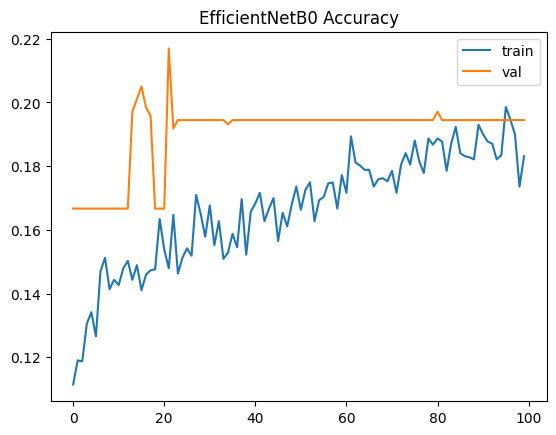

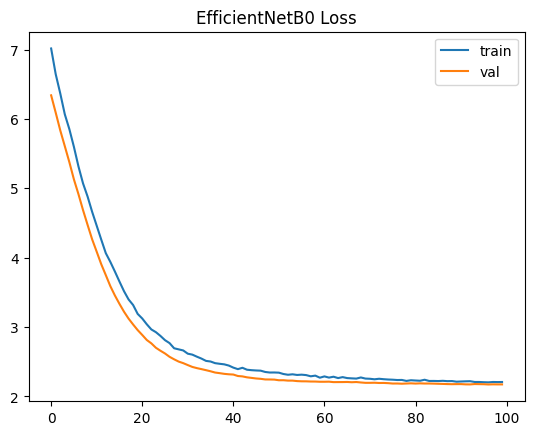

In [76]:
plt.plot(eff_history.history['accuracy'], label='train')
plt.plot(eff_history.history['val_accuracy'], label='val')
plt.title('EfficientNetB0 Accuracy')
plt.legend()
plt.show()

plt.plot(eff_history.history['loss'], label='train')
plt.plot(eff_history.history['val_loss'], label='val')
plt.title('EfficientNetB0 Loss')
plt.legend()
plt.show()

In [77]:
# Train set evaluations
aug_train_flow.reset()
true_labels_eff = aug_train_flow.classes
predicted_probs_eff = eff_model.predict(aug_train_flow, verbose=1)
predicted_labels_eff = np.argmax(predicted_probs_eff, axis=1)

print(classification_report(true_labels_eff, predicted_labels_eff, target_names=aug_train_flow.class_indices.keys()))

macro_f1_eff = f1_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_prec_eff = precision_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_recall_eff = recall_score(true_labels_eff, predicted_labels_eff, average='macro')
onehot_eff = np.eye(9)[true_labels_eff]
macro_auc_eff = roc_auc_score(onehot_eff, predicted_probs_eff, multi_class='ovr', average='macro')

print(f'Train F1: {macro_f1_eff:.4f} | Precision: {macro_prec_eff:.4f} | Recall: {macro_recall_eff:.4f} | AUC: {macro_auc_eff:.4f}')

381/381 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.00      0.00      0.00       295
      2-Food Organics       0.00      0.00      0.00       263
              3-Glass       0.00      0.00      0.00       269
              4-Metal       0.00      0.00      0.00       506
5-Miscellaneous Trash       0.00      0.00      0.00       317
              6-Paper       0.00      0.00      0.00       320
            7-Plastic       0.19      1.00      0.32       589
      8-Textile Trash       0.00      0.00      0.00       204
         9-Vegetation       0.00      0.00      0.00       279

             accuracy                           0.19      3042
            macro avg       0.02      0.11      0.04      3042
         weighted avg       0.04      0.19      0.06      3042

Train F1: 0.0360 | Precision: 0.0215 | Recall: 0.1111 | AUC: 0.5023


In [78]:
# Validation set evaluations
aug_val_flow.reset()
true_labels_eff = aug_val_flow.classes
predicted_probs_eff = eff_model.predict(aug_val_flow, verbose=1)
predicted_labels_eff = np.argmax(predicted_probs_eff, axis=1)

print(classification_report(true_labels_eff, predicted_labels_eff, target_names=aug_val_flow.class_indices.keys()))

macro_f1_eff = f1_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_prec_eff = precision_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_recall_eff = recall_score(true_labels_eff, predicted_labels_eff, average='macro')
onehot_eff = np.eye(9)[true_labels_eff]
macro_auc_eff = roc_auc_score(onehot_eff, predicted_probs_eff, multi_class='ovr', average='macro')

print(f'Val F1: {macro_f1_eff:.4f} | Precision: {macro_prec_eff:.4f} | Recall: {macro_recall_eff:.4f} | AUC: {macro_auc_eff:.4f}')

95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.00      0.00      0.00        73
      2-Food Organics       0.00      0.00      0.00        65
              3-Glass       0.00      0.00      0.00        67
              4-Metal       0.00      0.00      0.00       126
5-Miscellaneous Trash       0.00      0.00      0.00        79
              6-Paper       0.00      0.00      0.00        80
            7-Plastic       0.19      1.00      0.33       147
      8-Textile Trash       0.00      0.00      0.00        50
         9-Vegetation       0.00      0.00      0.00        69

             accuracy                           0.19       756
            macro avg       0.02      0.11      0.04       756
         weighted avg       0.04      0.19      0.06       756

Val F1: 0.0362 | Precision: 0.0216 | Recall: 0.1111 | AUC: 0.5075


In [79]:
# Test set evakuations
res_eval.reset()
true_labels_eff = res_eval.classes
predicted_probs_eff = eff_model.predict(res_eval, verbose=1)
predicted_labels_eff = np.argmax(predicted_probs_eff, axis=1)
print(classification_report(true_labels_eff, predicted_labels_eff, target_names=res_eval.class_indices.keys()))

macro_f1_eff = f1_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_prec_eff = precision_score(true_labels_eff, predicted_labels_eff, average='macro')
macro_recall_eff = recall_score(true_labels_eff, predicted_labels_eff, average='macro')
onehot_eff = np.eye(9)[true_labels_eff]
macro_auc_eff = roc_auc_score(onehot_eff, predicted_probs_eff, multi_class='ovr', average='macro')

print(f'F1: {macro_f1_eff:.4f} | Precision: {macro_prec_eff:.4f} | Recall: {macro_recall_eff:.4f} | AUC: {macro_auc_eff:.4f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.00      0.00      0.00        93
      2-Food Organics       0.00      0.00      0.00        83
              3-Glass       0.00      0.00      0.00        84
              4-Metal       0.00      0.00      0.00       158
5-Miscellaneous Trash       0.00      0.00      0.00        99
              6-Paper       0.00      0.00      0.00       100
            7-Plastic       0.19      1.00      0.32       185
      8-Textile Trash       0.00      0.00      0.00        64
         9-Vegetation       0.00      0.00      0.00        88

             accuracy                           0.19       954
            macro avg       0.02      0.11      0.04       954
         weighted avg       0.04      0.19      0.06       954

F1: 0.0361 | Precision: 0.0215 | Recall: 0.1111 | AUC: 0.6869


In [80]:
# VGG16
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_base.layers:
    layer.trainable = False

v = vgg_base.output
v = GlobalAveragePooling2D()(v)
v = BatchNormalization()(v)
v = Dropout(0.3)(v)
v = Dense(256, activation='relu', kernel_regularizer='l2')(v)
v = BatchNormalization()(v)
v = Dropout(0.3)(v)
vgg_out = Dense(9, activation='softmax')(v)
# kernel_regularizer='l2' add this to softmax as well

vgg_model = Model(inputs=vgg_base.input, outputs=vgg_out)
vgg_model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [81]:
vgg_ckpt = '/content/best_vgg16_augmented_model.h5'

early_stop_vgg = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_save_vgg = ModelCheckpoint(filepath=vgg_ckpt, monitor='val_loss', save_best_only=True)

vgg_history = vgg_model.fit(
    aug_train_flow,
    epochs=100,
    validation_data=aug_val_flow,
    callbacks=[early_stop_vgg, model_save_vgg],
    verbose=1
)

Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.1852 - loss: 6.0769

381/381 ━━━━━━━━━━━━━━━━━━━━ 55s 132ms/step - accuracy: 0.1854 - loss: 6.0759 - val_accuracy: 0.3558 - val_loss: 5.0348
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3590 - loss: 5.1232

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.3591 - loss: 5.1228 - val_accuracy: 0.4577 - val_loss: 4.6119
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4319 - loss: 4.6691

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.4319 - loss: 4.6690 - val_accuracy: 0.5093 - val_loss: 4.3707
Epoch 4/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4423 - loss: 4.4733

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.4424 - loss: 4.4731 - val_accuracy: 0.5132 - val_loss: 4.1986
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5303 - loss: 4.0573

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.5302 - loss: 4.0574 - val_accuracy: 0.5172 - val_loss: 3.9955
Epoch 6/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5206 - loss: 3.9335

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.5207 - loss: 3.9334 - val_accuracy: 0.5622 - val_loss: 3.8147
Epoch 7/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5698 - loss: 3.7260

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.5698 - loss: 3.7259 - val_accuracy: 0.5384 - val_loss: 3.7369
Epoch 8/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5825 - loss: 3.5292

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.5825 - loss: 3.5292 - val_accuracy: 0.5701 - val_loss: 3.5613
Epoch 9/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5627 - loss: 3.4643

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.5627 - loss: 3.4642 - val_accuracy: 0.5794 - val_loss: 3.4140
Epoch 10/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5804 - loss: 3.2827

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.5804 - loss: 3.2826 - val_accuracy: 0.5675 - val_loss: 3.3600
Epoch 11/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5929 - loss: 3.1287

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.5929 - loss: 3.1286 - val_accuracy: 0.5873 - val_loss: 3.2101
Epoch 12/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6126 - loss: 3.0158

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.6126 - loss: 3.0159 - val_accuracy: 0.5926 - val_loss: 3.0786
Epoch 13/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6272 - loss: 2.8878

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.6272 - loss: 2.8878 - val_accuracy: 0.5820 - val_loss: 3.0147
Epoch 14/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6424 - loss: 2.7501

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.6423 - loss: 2.7502 - val_accuracy: 0.6151 - val_loss: 2.9210
Epoch 15/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6177 - loss: 2.7250

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.6178 - loss: 2.7249 - val_accuracy: 0.5899 - val_loss: 2.8025
Epoch 16/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6163 - loss: 2.6512

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.6163 - loss: 2.6510 - val_accuracy: 0.5860 - val_loss: 2.7599
Epoch 17/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6483 - loss: 2.5405

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.6484 - loss: 2.5404 - val_accuracy: 0.6098 - val_loss: 2.6681
Epoch 18/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6466 - loss: 2.4337

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.6466 - loss: 2.4337 - val_accuracy: 0.6085 - val_loss: 2.6298
Epoch 19/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6254 - loss: 2.4441

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.6254 - loss: 2.4440 - val_accuracy: 0.6151 - val_loss: 2.5416
Epoch 20/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6645 - loss: 2.2963

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.6645 - loss: 2.2963 - val_accuracy: 0.6177 - val_loss: 2.4801
Epoch 21/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6662 - loss: 2.2147

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.6662 - loss: 2.2146 - val_accuracy: 0.6032 - val_loss: 2.4309
Epoch 22/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6517 - loss: 2.1722

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.6517 - loss: 2.1722 - val_accuracy: 0.6177 - val_loss: 2.3473
Epoch 23/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6437 - loss: 2.1407

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.6438 - loss: 2.1406 - val_accuracy: 0.6045 - val_loss: 2.3397
Epoch 24/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6575 - loss: 2.0641

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.6575 - loss: 2.0641 - val_accuracy: 0.5979 - val_loss: 2.2761
Epoch 25/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6550 - loss: 2.0091

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.6550 - loss: 2.0091 - val_accuracy: 0.6217 - val_loss: 2.2326
Epoch 26/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6665 - loss: 1.9647

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.6665 - loss: 1.9646 - val_accuracy: 0.6098 - val_loss: 2.2091
Epoch 27/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6742 - loss: 1.8946

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.6742 - loss: 1.8945 - val_accuracy: 0.6098 - val_loss: 2.1990
Epoch 28/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6802 - loss: 1.8246

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.6802 - loss: 1.8247 - val_accuracy: 0.6071 - val_loss: 2.1029
Epoch 29/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.6787 - loss: 1.8340 - val_accuracy: 0.5952 - val_loss: 2.1306
Epoch 30/100
380/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6904 - loss: 1.7336

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.6904 - loss: 1.7336 - val_accuracy: 0.6164 - val_loss: 2.0286
Epoch 31/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6731 - loss: 1.7252

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.6731 - loss: 1.7252 - val_accuracy: 0.6310 - val_loss: 1.9779
Epoch 32/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.6960 - loss: 1.6754 - val_accuracy: 0.6111 - val_loss: 2.0022
Epoch 33/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7025 - loss: 1.6179

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7025 - loss: 1.6179 - val_accuracy: 0.6164 - val_loss: 1.9303
Epoch 34/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6964 - loss: 1.6175

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.6964 - loss: 1.6176 - val_accuracy: 0.6230 - val_loss: 1.9277
Epoch 35/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6810 - loss: 1.6202

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.6810 - loss: 1.6202 - val_accuracy: 0.6151 - val_loss: 1.8906
Epoch 36/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7002 - loss: 1.5463

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.7002 - loss: 1.5463 - val_accuracy: 0.6124 - val_loss: 1.8881
Epoch 37/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7321 - loss: 1.4818

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7321 - loss: 1.4819 - val_accuracy: 0.6257 - val_loss: 1.8561
Epoch 38/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6745 - loss: 1.5511

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.6746 - loss: 1.5511 - val_accuracy: 0.6230 - val_loss: 1.8089
Epoch 39/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7124 - loss: 1.4422

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.7124 - loss: 1.4423 - val_accuracy: 0.6124 - val_loss: 1.7932
Epoch 40/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7172 - loss: 1.4272

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.7172 - loss: 1.4272 - val_accuracy: 0.6164 - val_loss: 1.7702
Epoch 41/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7178 - loss: 1.4112

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7179 - loss: 1.4112 - val_accuracy: 0.6270 - val_loss: 1.7411
Epoch 42/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7200 - loss: 1.4078 - val_accuracy: 0.6243 - val_loss: 1.7531
Epoch 43/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7181 - loss: 1.3703

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.7180 - loss: 1.3704 - val_accuracy: 0.6217 - val_loss: 1.7080
Epoch 44/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.7178 - loss: 1.3353 - val_accuracy: 0.6151 - val_loss: 1.7119
Epoch 45/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7113 - loss: 1.3322

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.7113 - loss: 1.3322 - val_accuracy: 0.6296 - val_loss: 1.6867
Epoch 46/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7211 - loss: 1.3200

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7211 - loss: 1.3201 - val_accuracy: 0.6217 - val_loss: 1.6578
Epoch 47/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7235 - loss: 1.2768 - val_accuracy: 0.6270 - val_loss: 1.6589
Epoch 48/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7133 - loss: 1.2811

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.7133 - loss: 1.2811 - val_accuracy: 0.6362 - val_loss: 1.6279
Epoch 49/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7220 - loss: 1.2622

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.7220 - loss: 1.2622 - val_accuracy: 0.6310 - val_loss: 1.5999
Epoch 50/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7080 - loss: 1.2485 - val_accuracy: 0.6376 - val_loss: 1.6138
Epoch 51/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7420 - loss: 1.1868

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7420 - loss: 1.1869 - val_accuracy: 0.6429 - val_loss: 1.5856
Epoch 52/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.7041 - loss: 1.2363 - val_accuracy: 0.6389 - val_loss: 1.5866
Epoch 53/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7411 - loss: 1.1794

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.7411 - loss: 1.1794 - val_accuracy: 0.6270 - val_loss: 1.5770
Epoch 54/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7476 - loss: 1.1703

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7475 - loss: 1.1703 - val_accuracy: 0.6323 - val_loss: 1.5524
Epoch 55/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.7235 - loss: 1.1920 - val_accuracy: 0.6164 - val_loss: 1.5789
Epoch 56/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7205 - loss: 1.1945

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7206 - loss: 1.1944 - val_accuracy: 0.6323 - val_loss: 1.5427
Epoch 57/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.7273 - loss: 1.1748 - val_accuracy: 0.6283 - val_loss: 1.5652
Epoch 58/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7245 - loss: 1.1580

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.7244 - loss: 1.1580 - val_accuracy: 0.6429 - val_loss: 1.5250
Epoch 59/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7267 - loss: 1.1360

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.7267 - loss: 1.1361 - val_accuracy: 0.6389 - val_loss: 1.5122
Epoch 60/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7205 - loss: 1.1796

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.7205 - loss: 1.1795 - val_accuracy: 0.6389 - val_loss: 1.4898
Epoch 61/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.7620 - loss: 1.0414 - val_accuracy: 0.6481 - val_loss: 1.4956
Epoch 62/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7253 - loss: 1.1042

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7253 - loss: 1.1043 - val_accuracy: 0.6429 - val_loss: 1.4861
Epoch 63/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7403 - loss: 1.0843 - val_accuracy: 0.6415 - val_loss: 1.4891
Epoch 64/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7354 - loss: 1.0915

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.7354 - loss: 1.0915 - val_accuracy: 0.6283 - val_loss: 1.4562
Epoch 65/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7288 - loss: 1.0954 - val_accuracy: 0.6270 - val_loss: 1.4746
Epoch 66/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7211 - loss: 1.1004

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.7211 - loss: 1.1004 - val_accuracy: 0.6534 - val_loss: 1.4509
Epoch 67/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7224 - loss: 1.1041 - val_accuracy: 0.6468 - val_loss: 1.4679
Epoch 68/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7582 - loss: 0.9986 - val_accuracy: 0.6177 - val_loss: 1.4808
Epoch 69/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7570 - loss: 1.0355

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7570 - loss: 1.0356 - val_accuracy: 0.6310 - val_loss: 1.4505
Epoch 70/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7660 - loss: 1.0094

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.7659 - loss: 1.0094 - val_accuracy: 0.6323 - val_loss: 1.4481
Epoch 71/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7567 - loss: 0.9901 - val_accuracy: 0.6349 - val_loss: 1.4496
Epoch 72/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7419 - loss: 1.0205

381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.7419 - loss: 1.0206 - val_accuracy: 0.6455 - val_loss: 1.4280
Epoch 73/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7594 - loss: 0.9840

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.7594 - loss: 0.9842 - val_accuracy: 0.6349 - val_loss: 1.4046
Epoch 74/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.7415 - loss: 1.0086 - val_accuracy: 0.6349 - val_loss: 1.4222
Epoch 75/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.7509 - loss: 0.9745 - val_accuracy: 0.6270 - val_loss: 1.4115
Epoch 76/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7342 - loss: 0.9864 - val_accuracy: 0.6455 - val_loss: 1.4245
Epoch 77/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7600 - loss: 0.9688 - val_accuracy: 0.6442 - val_loss: 1.4403
Epoch 78/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7631 - loss: 0.9555

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7631 - loss: 0.9556 - val_accuracy: 0.6429 - val_loss: 1.4000
Epoch 79/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7428 - loss: 0.9752

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7428 - loss: 0.9752 - val_accuracy: 0.6495 - val_loss: 1.3853
Epoch 80/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 45s 119ms/step - accuracy: 0.7510 - loss: 0.9681 - val_accuracy: 0.6283 - val_loss: 1.3920
Epoch 81/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7564 - loss: 0.9400

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.7564 - loss: 0.9400 - val_accuracy: 0.6376 - val_loss: 1.3788
Epoch 82/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.7625 - loss: 0.9189 - val_accuracy: 0.6283 - val_loss: 1.4118
Epoch 83/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7444 - loss: 0.9679

381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7444 - loss: 0.9679 - val_accuracy: 0.6429 - val_loss: 1.3467
Epoch 84/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.7524 - loss: 0.9615 - val_accuracy: 0.6362 - val_loss: 1.4067
Epoch 85/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.7502 - loss: 0.9363 - val_accuracy: 0.6230 - val_loss: 1.4230
Epoch 86/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.7478 - loss: 0.9753 - val_accuracy: 0.6481 - val_loss: 1.3810
Epoch 87/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.7623 - loss: 0.9541 - val_accuracy: 0.6310 - val_loss: 1.4050
Epoch 88/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.7545 - loss: 0.9137 - val_accuracy: 0.6402 - val_loss: 1.3591
Epoch 89/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - accuracy: 0.7692 - loss: 0.9093 - val_accuracy: 0.6521 - val_loss: 1.3495
Epoch 90/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 45s 119ms/step - accuracy: 0.7599 - loss

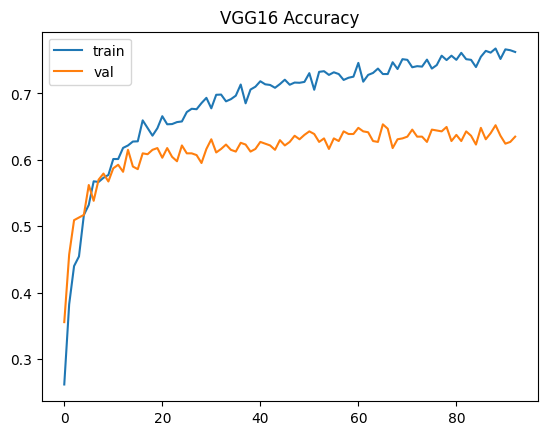

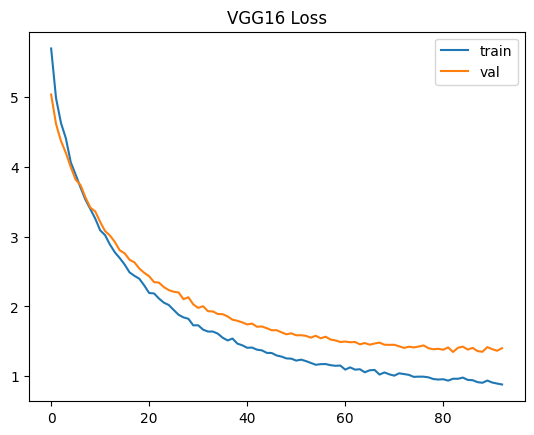

In [82]:
plt.plot(vgg_history.history['accuracy'], label='train')
plt.plot(vgg_history.history['val_accuracy'], label='val')
plt.title('VGG16 Accuracy')
plt.legend()
plt.show()

plt.plot(vgg_history.history['loss'], label='train')
plt.plot(vgg_history.history['val_loss'], label='val')
plt.title('VGG16 Loss')
plt.legend()
plt.show()

In [83]:
# Train set evaluations
aug_train_flow.reset()
true_labels_vgg = aug_train_flow.classes
predicted_probs_vgg = vgg_model.predict(aug_train_flow, verbose=1)
predicted_labels_vgg = np.argmax(predicted_probs_vgg, axis=1)

print(classification_report(true_labels_vgg, predicted_labels_vgg, target_names=aug_train_flow.class_indices.keys()))

macro_f1_vgg = f1_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_prec_vgg = precision_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_recall_vgg = recall_score(true_labels_vgg, predicted_labels_vgg, average='macro')
onehot_vgg = np.eye(9)[true_labels_vgg]
macro_auc_vgg = roc_auc_score(onehot_vgg, predicted_probs_vgg, multi_class='ovr', average='macro')

print(f'Train F1: {macro_f1_vgg:.4f} | Precision: {macro_prec_vgg:.4f} | Recall: {macro_recall_vgg:.4f} | AUC: {macro_auc_vgg:.4f}')

381/381 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.11      0.11      0.11       295
      2-Food Organics       0.07      0.08      0.08       263
              3-Glass       0.07      0.07      0.07       269
              4-Metal       0.14      0.14      0.14       506
5-Miscellaneous Trash       0.13      0.12      0.13       317
              6-Paper       0.11      0.12      0.12       320
            7-Plastic       0.21      0.22      0.21       589
      8-Textile Trash       0.07      0.07      0.07       204
         9-Vegetation       0.08      0.08      0.08       279

             accuracy                           0.13      3042
            macro avg       0.11      0.11      0.11      3042
         weighted avg       0.13      0.13      0.13      3042

Train F1: 0.1113 | Precision: 0.1114 | Recall: 0.1114 | AUC: 0.5036


In [84]:
# Validation set evaluations
aug_val_flow.reset()
true_labels_vgg = aug_val_flow.classes
predicted_probs_vgg = vgg_model.predict(aug_val_flow, verbose=1)
predicted_labels_vgg = np.argmax(predicted_probs_vgg, axis=1)

print(classification_report(true_labels_vgg, predicted_labels_vgg, target_names=aug_val_flow.class_indices.keys()))

macro_f1_vgg = f1_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_prec_vgg = precision_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_recall_vgg = recall_score(true_labels_vgg, predicted_labels_vgg, average='macro')
onehot_vgg = np.eye(9)[true_labels_vgg]
macro_auc_vgg = roc_auc_score(onehot_vgg, predicted_probs_vgg, multi_class='ovr', average='macro')

print(f'Val F1: {macro_f1_vgg:.4f} | Precision: {macro_prec_vgg:.4f} | Recall: {macro_recall_vgg:.4f} | AUC: {macro_auc_vgg:.4f}')

95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.02      0.01      0.02        73
      2-Food Organics       0.13      0.12      0.13        65
              3-Glass       0.09      0.10      0.10        67
              4-Metal       0.16      0.18      0.17       126
5-Miscellaneous Trash       0.05      0.05      0.05        79
              6-Paper       0.11      0.11      0.11        80
            7-Plastic       0.18      0.16      0.17       147
      8-Textile Trash       0.06      0.08      0.07        50
         9-Vegetation       0.04      0.04      0.04        69

             accuracy                           0.11       756
            macro avg       0.09      0.10      0.10       756
         weighted avg       0.11      0.11      0.11       756

Val F1: 0.0955 | Precision: 0.0949 | Recall: 0.0971 | AUC: 0.4914


In [85]:
# Test set evaluations
res_eval.reset()
true_labels_vgg = res_eval.classes
predicted_probs_vgg = vgg_model.predict(res_eval, verbose=1)
predicted_labels_vgg = np.argmax(predicted_probs_vgg, axis=1)
print(classification_report(true_labels_vgg, predicted_labels_vgg, target_names=res_eval.class_indices.keys()))

macro_f1_vgg = f1_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_prec_vgg = precision_score(true_labels_vgg, predicted_labels_vgg, average='macro')
macro_recall_vgg = recall_score(true_labels_vgg, predicted_labels_vgg, average='macro')
onehot_vgg = np.eye(9)[true_labels_vgg]
macro_auc_vgg = roc_auc_score(onehot_vgg, predicted_probs_vgg, multi_class='ovr', average='macro')

print(f'F1: {macro_f1_vgg:.4f} | Precision: {macro_prec_vgg:.4f} | Recall: {macro_recall_vgg:.4f} | AUC: {macro_auc_vgg:.4f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.82      0.74      0.78        93
      2-Food Organics       0.86      0.83      0.85        83
              3-Glass       0.79      0.75      0.77        84
              4-Metal       0.75      0.77      0.76       158
5-Miscellaneous Trash       0.69      0.59      0.63        99
              6-Paper       0.83      0.81      0.82       100
            7-Plastic       0.74      0.80      0.77       185
      8-Textile Trash       0.72      0.77      0.74        64
         9-Vegetation       0.85      0.93      0.89        88

             accuracy                           0.78       954
            macro avg       0.78      0.78      0.78       954
         weighted avg       0.78      0.78      0.78       954

F1: 0.7783 | Precision: 0.7826 | Recall: 0.7765 | AUC: 0.9679


In [86]:
# Comparison summary
acc_resnet50 = np.mean(predicted_labels == true_labels)
acc_resnet101 = np.mean(predicted_labels_101 == true_labels_101)
acc_efficientnet = np.mean(predicted_labels_eff == true_labels_eff)
acc_vgg16 = np.mean(predicted_labels_vgg == true_labels_vgg)

summary_df = pd.DataFrame({
    'Model': ['ResNet50', 'ResNet101', 'EfficientNetB0', 'VGG16'],
    'Accuracy': [acc_resnet50, acc_resnet101, acc_efficientnet, acc_vgg16],
    'Precision': [macro_prec, macro_prec_101, macro_prec_eff, macro_prec_vgg],
    'Recall': [macro_recall, macro_recall_101, macro_recall_eff, macro_recall_vgg],
    'F1 Score': [macro_f1, macro_f1_101, macro_f1_eff, macro_f1_vgg],
    'AUC': [macro_auc, macro_auc_101, macro_auc_eff, macro_auc_vgg]
}).round(4).set_index('Model')

summary_df

,Accuracy,Precision,Recall,F1 Score,AUC
Model,,,,,
ResNet50,0.5136,0.5199,0.4800,0.4670,0.8726
ResNet101,0.4644,0.4567,0.4355,0.4189,0.8488
EfficientNetB0,0.1939,0.0215,0.1111,0.0361,0.6869
VGG16,0.7767,0.7826,0.7765,0.7783,0.9679
